In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rpy2.robjects as robjects
import rpy2.robjects.pandas2ri as pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr, isinstalled
import rpy2.robjects.packages as rpackages
from rpy2.robjects import r
import sys

import sys
sys.path.insert(0, '/Users/alanma/Documents/CFA_python')
import faircause.faircause as faircause
import faircause.fairprediction as fairprediction
from faircause.utils.prediction_helpers import *

from sklearn.model_selection import train_test_split


In [2]:
# import
base = importr('base')
faircause = importr('faircause')

# Load census dataset
data = robjects.r('''
    get(data("compas", package = "faircause"))

''')

# Convert to pd
with localconverter(robjects.default_converter + pandas2ri.converter):
  data = robjects.conversion.rpy2py(data)
data.reset_index(drop=True, inplace=True)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [3]:
data.head()

,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,two_year_recid
0,Male,69,Non-White,0,0,0,0,F,0
1,Male,34,Non-White,0,0,0,0,F,1
2,Male,24,Non-White,0,0,1,4,F,1
3,Male,23,Non-White,0,1,0,1,F,0
4,Male,43,Non-White,0,0,0,2,F,0


In [4]:
# one hot
data['sex'] = (data['sex'] != 'Male').astype(int)
data['race'] = (data['race'] != 'White').astype(int)
data['c_charge_degree'] = (data['c_charge_degree'] != 'M').astype(int)

In [5]:
X = "race"
W = ["juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count",
        "c_charge_degree"]
Z = ["age", "sex"]
Y = "two_year_recid"
x0 = 0
x1 = 1

In [8]:
import faircause.fairprediction as fairprediction

lmbd_size = [0.1, 1, 2, 5, 10]
auc = []
causal_loss = []
BN = ["IE"]
for lmbd in lmbd_size: 
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
    train_data = train_data.reset_index(drop=True)
    test_data = test_data.reset_index(drop=True)

    fair_pred = fairprediction.FairPredict(train_data, X, Z, W, Y, 
                                       x0=x0, x1=x1, BN=["IE"], lmbd_seq=[lmbd], random_seed=42)
    fair_pred.train()
    preds = fair_pred.predict(test_data)
    auc.append(acc_measure(test_data[Y], preds['predictions'][lmbd], "auc"))
    l = 0
    for i in ['nde', 'expse_x0', 'expse_x1']: #no nie as nie in BN set
        l += np.abs(preds['test_meas'].loc[preds['test_meas']['measure'] == i, 'value'].iloc[0])
    causal_loss.append(l)


/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:163: RuntimeWarning: divide by zero encountered in divide
  y1[ts] = (Y.loc[ts].values - y_z1_ts) * (X.loc[ts] == 1).values / (px_z_ts) + y_z1_ts


4.89 percent of extreme P(x|z) or p(x|z,w) prob
 Reported results are for the overlap pop. Consider investigating overlap issues


/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:162: RuntimeWarning: invalid value encountered in divide
  y0[ts] = (Y.loc[ts].values - y_z0_ts) * (X.loc[ts] == 0).values / (1-px_z_ts) + y_z0_ts
/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:162: RuntimeWarning: invalid value encountered in divide
  y0[ts] = (Y.loc[ts].values - y_z0_ts) * (X.loc[ts] == 0).values / (1-px_z_ts) + y_z0_ts
/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:162: RuntimeWarning: divide by zero encountered in divide
  y0[ts] = (Y.loc[ts].values - y_z0_ts) * (X.loc[ts] == 0).values / (1-px_z_ts) + y_z0_ts
/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:162: RuntimeWarning: invalid value encountered in divide
  y0[ts] = (Y.loc[ts].values - y_z0_ts) * (X.loc[ts] == 0).values / (1-px_z_ts) + y_z0_ts
/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:162: RuntimeWarning: divide by zero encountere

8.39 percent of extreme P(x|z) or p(x|z,w) prob
 Reported results are for the overlap pop. Consider investigating overlap issues


/Users/alanma/Documents/CFA_python/faircause/utils/prediction_helpers.py:43: RuntimeWarning: divide by zero encountered in log
  ret = -np.mean(y * np.log(p_safe) + (1 - y) * np.log(1 - p_safe))
/Users/alanma/Documents/CFA_python/faircause/utils/prediction_helpers.py:43: RuntimeWarning: invalid value encountered in multiply
  ret = -np.mean(y * np.log(p_safe) + (1 - y) * np.log(1 - p_safe))
/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:163: RuntimeWarning: invalid value encountered in divide
  y1[ts] = (Y.loc[ts].values - y_z1_ts) * (X.loc[ts] == 1).values / (px_z_ts) + y_z1_ts
/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:162: RuntimeWarning: divide by zero encountered in divide
  y0[ts] = (Y.loc[ts].values - y_z0_ts) * (X.loc[ts] == 0).values / (1-px_z_ts) + y_z0_ts
/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:162: RuntimeWarning: invalid value encountered in divide
  y0[ts] = (Y.loc[ts].values - y_z0_t

5.54 percent of extreme P(x|z) or p(x|z,w) prob
 Reported results are for the overlap pop. Consider investigating overlap issues


/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:163: RuntimeWarning: divide by zero encountered in divide
  y1[ts] = (Y.loc[ts].values - y_z1_ts) * (X.loc[ts] == 1).values / (px_z_ts) + y_z1_ts


4.89 percent of extreme P(x|z) or p(x|z,w) prob
 Reported results are for the overlap pop. Consider investigating overlap issues


/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:162: RuntimeWarning: invalid value encountered in divide
  y0[ts] = (Y.loc[ts].values - y_z0_ts) * (X.loc[ts] == 0).values / (1-px_z_ts) + y_z0_ts
/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:162: RuntimeWarning: invalid value encountered in divide
  y0[ts] = (Y.loc[ts].values - y_z0_ts) * (X.loc[ts] == 0).values / (1-px_z_ts) + y_z0_ts
/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:162: RuntimeWarning: divide by zero encountered in divide
  y0[ts] = (Y.loc[ts].values - y_z0_ts) * (X.loc[ts] == 0).values / (1-px_z_ts) + y_z0_ts
/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:162: RuntimeWarning: invalid value encountered in divide
  y0[ts] = (Y.loc[ts].values - y_z0_ts) * (X.loc[ts] == 0).values / (1-px_z_ts) + y_z0_ts
/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:162: RuntimeWarning: divide by zero encountere

8.39 percent of extreme P(x|z) or p(x|z,w) prob
 Reported results are for the overlap pop. Consider investigating overlap issues


/Users/alanma/Documents/CFA_python/faircause/utils/prediction_helpers.py:43: RuntimeWarning: divide by zero encountered in log
  ret = -np.mean(y * np.log(p_safe) + (1 - y) * np.log(1 - p_safe))
/Users/alanma/Documents/CFA_python/faircause/utils/prediction_helpers.py:43: RuntimeWarning: invalid value encountered in multiply
  ret = -np.mean(y * np.log(p_safe) + (1 - y) * np.log(1 - p_safe))
/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:163: RuntimeWarning: invalid value encountered in divide
  y1[ts] = (Y.loc[ts].values - y_z1_ts) * (X.loc[ts] == 1).values / (px_z_ts) + y_z1_ts
/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:162: RuntimeWarning: divide by zero encountered in divide
  y0[ts] = (Y.loc[ts].values - y_z0_ts) * (X.loc[ts] == 0).values / (1-px_z_ts) + y_z0_ts
/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:162: RuntimeWarning: invalid value encountered in divide
  y0[ts] = (Y.loc[ts].values - y_z0_t

5.54 percent of extreme P(x|z) or p(x|z,w) prob
 Reported results are for the overlap pop. Consider investigating overlap issues


/Users/alanma/Documents/CFA_python/faircause/utils/prediction_helpers.py:43: RuntimeWarning: divide by zero encountered in log
  ret = -np.mean(y * np.log(p_safe) + (1 - y) * np.log(1 - p_safe))
/Users/alanma/.conda/envs/cfa/lib/python3.13/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:163: RuntimeWarning: divide by zero encountered in divide
  y1[ts] = (Y.loc[ts].values - y_z1_ts) * (X.loc[ts] == 1).values / (px_z_ts) + y_z1_ts


4.89 percent of extreme P(x|z) or p(x|z,w) prob
 Reported results are for the overlap pop. Consider investigating overlap issues


/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:162: RuntimeWarning: invalid value encountered in divide
  y0[ts] = (Y.loc[ts].values - y_z0_ts) * (X.loc[ts] == 0).values / (1-px_z_ts) + y_z0_ts
/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:162: RuntimeWarning: invalid value encountered in divide
  y0[ts] = (Y.loc[ts].values - y_z0_ts) * (X.loc[ts] == 0).values / (1-px_z_ts) + y_z0_ts
/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:162: RuntimeWarning: divide by zero encountered in divide
  y0[ts] = (Y.loc[ts].values - y_z0_ts) * (X.loc[ts] == 0).values / (1-px_z_ts) + y_z0_ts
/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:162: RuntimeWarning: invalid value encountered in divide
  y0[ts] = (Y.loc[ts].values - y_z0_ts) * (X.loc[ts] == 0).values / (1-px_z_ts) + y_z0_ts
/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:162: RuntimeWarning: divide by zero encountere

8.39 percent of extreme P(x|z) or p(x|z,w) prob
 Reported results are for the overlap pop. Consider investigating overlap issues


/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:163: RuntimeWarning: invalid value encountered in divide
  y1[ts] = (Y.loc[ts].values - y_z1_ts) * (X.loc[ts] == 1).values / (px_z_ts) + y_z1_ts
/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:162: RuntimeWarning: divide by zero encountered in divide
  y0[ts] = (Y.loc[ts].values - y_z0_ts) * (X.loc[ts] == 0).values / (1-px_z_ts) + y_z0_ts
/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:162: RuntimeWarning: invalid value encountered in divide
  y0[ts] = (Y.loc[ts].values - y_z0_ts) * (X.loc[ts] == 0).values / (1-px_z_ts) + y_z0_ts


5.54 percent of extreme P(x|z) or p(x|z,w) prob
 Reported results are for the overlap pop. Consider investigating overlap issues


/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:163: RuntimeWarning: divide by zero encountered in divide
  y1[ts] = (Y.loc[ts].values - y_z1_ts) * (X.loc[ts] == 1).values / (px_z_ts) + y_z1_ts


4.89 percent of extreme P(x|z) or p(x|z,w) prob
 Reported results are for the overlap pop. Consider investigating overlap issues


/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:162: RuntimeWarning: invalid value encountered in divide
  y0[ts] = (Y.loc[ts].values - y_z0_ts) * (X.loc[ts] == 0).values / (1-px_z_ts) + y_z0_ts
/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:162: RuntimeWarning: invalid value encountered in divide
  y0[ts] = (Y.loc[ts].values - y_z0_ts) * (X.loc[ts] == 0).values / (1-px_z_ts) + y_z0_ts
/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:162: RuntimeWarning: divide by zero encountered in divide
  y0[ts] = (Y.loc[ts].values - y_z0_ts) * (X.loc[ts] == 0).values / (1-px_z_ts) + y_z0_ts
/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:162: RuntimeWarning: invalid value encountered in divide
  y0[ts] = (Y.loc[ts].values - y_z0_ts) * (X.loc[ts] == 0).values / (1-px_z_ts) + y_z0_ts
/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:162: RuntimeWarning: divide by zero encountere

8.39 percent of extreme P(x|z) or p(x|z,w) prob
 Reported results are for the overlap pop. Consider investigating overlap issues


/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:163: RuntimeWarning: invalid value encountered in divide
  y1[ts] = (Y.loc[ts].values - y_z1_ts) * (X.loc[ts] == 1).values / (px_z_ts) + y_z1_ts
/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:162: RuntimeWarning: divide by zero encountered in divide
  y0[ts] = (Y.loc[ts].values - y_z0_ts) * (X.loc[ts] == 0).values / (1-px_z_ts) + y_z0_ts
/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:162: RuntimeWarning: invalid value encountered in divide
  y0[ts] = (Y.loc[ts].values - y_z0_ts) * (X.loc[ts] == 0).values / (1-px_z_ts) + y_z0_ts


5.54 percent of extreme P(x|z) or p(x|z,w) prob
 Reported results are for the overlap pop. Consider investigating overlap issues


/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:163: RuntimeWarning: divide by zero encountered in divide
  y1[ts] = (Y.loc[ts].values - y_z1_ts) * (X.loc[ts] == 1).values / (px_z_ts) + y_z1_ts


4.89 percent of extreme P(x|z) or p(x|z,w) prob
 Reported results are for the overlap pop. Consider investigating overlap issues


/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:162: RuntimeWarning: invalid value encountered in divide
  y0[ts] = (Y.loc[ts].values - y_z0_ts) * (X.loc[ts] == 0).values / (1-px_z_ts) + y_z0_ts
/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:162: RuntimeWarning: invalid value encountered in divide
  y0[ts] = (Y.loc[ts].values - y_z0_ts) * (X.loc[ts] == 0).values / (1-px_z_ts) + y_z0_ts
/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:162: RuntimeWarning: divide by zero encountered in divide
  y0[ts] = (Y.loc[ts].values - y_z0_ts) * (X.loc[ts] == 0).values / (1-px_z_ts) + y_z0_ts
/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:162: RuntimeWarning: invalid value encountered in divide
  y0[ts] = (Y.loc[ts].values - y_z0_ts) * (X.loc[ts] == 0).values / (1-px_z_ts) + y_z0_ts
/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:162: RuntimeWarning: divide by zero encountere

8.39 percent of extreme P(x|z) or p(x|z,w) prob
 Reported results are for the overlap pop. Consider investigating overlap issues


/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:163: RuntimeWarning: invalid value encountered in divide
  y1[ts] = (Y.loc[ts].values - y_z1_ts) * (X.loc[ts] == 1).values / (px_z_ts) + y_z1_ts
/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:162: RuntimeWarning: divide by zero encountered in divide
  y0[ts] = (Y.loc[ts].values - y_z0_ts) * (X.loc[ts] == 0).values / (1-px_z_ts) + y_z0_ts
/Users/alanma/Documents/CFA_python/faircause/estimation/mediation_dml.py:162: RuntimeWarning: invalid value encountered in divide
  y0[ts] = (Y.loc[ts].values - y_z0_ts) * (X.loc[ts] == 0).values / (1-px_z_ts) + y_z0_ts


5.54 percent of extreme P(x|z) or p(x|z,w) prob
 Reported results are for the overlap pop. Consider investigating overlap issues


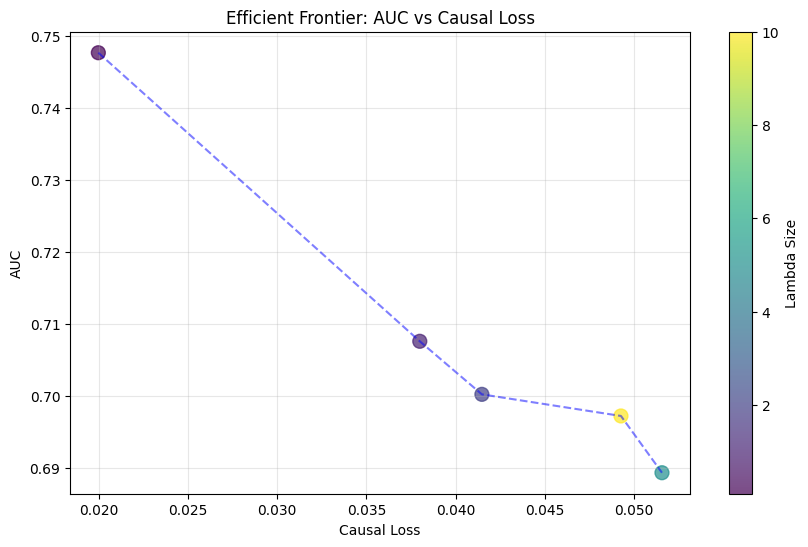

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(causal_loss, auc, c=lmbd_size,  s=100, alpha=0.7)
plt.colorbar(label='Lambda Size')

points = sorted(zip(causal_loss, auc, lmbd_size))
causal_loss_sorted, auc_sorted, _ = zip(*points)
plt.plot(causal_loss_sorted, auc_sorted, 'b--', alpha=0.5)

plt.xlabel('Causal Loss')
plt.ylabel('AUC')
plt.title('Efficient Frontier: AUC vs Causal Loss')
plt.grid(True, alpha=0.3)
